In [1]:
# This notebook creates spectrogram images from a directory of sound files in .wav format.
# The code is optimized to be processed in parallel on multi-core machines.

In [2]:
# Spectogram generation library
# https://librosa.org/doc/latest/index.html
import sys
!conda install --yes --prefix {sys.prefix} librosa

/bin/bash: line 1: conda: command not found


In [3]:
# imports

# With the exception of the librosa library installed above, all of these modules are 
# either included in the code base or provided by default on Amazon Sagemaker. 

import gc
import glob
import io
import multiprocessing as mp
import os
import os.path
import pickle
import pprint
import random
import time
from multiprocessing import Pool
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from db import NABat_DB
from IPython.display import Image
from PIL import Image
from spectrogram import Spectrogram


In [4]:
# Test we have a valid database and enumerate the species represented.
db = NABat_DB()
species = db.query(' select * from species;')
pprint.pprint(species)
db.conn.close()


[Row(id=1, species_code='ANPA', common_name='Pallid bat', min_frequency=27000, max_frequency=51000, available=1),
 Row(id=2, species_code='CHME', common_name='Mexican long-tongued bat', min_frequency=4999, max_frequency=99999, available=1),
 Row(id=3, species_code='CORA', common_name="Rafinesque's big-eared bat", min_frequency=4999, max_frequency=99999, available=1),
 Row(id=4, species_code='COTO', common_name="Townsend's big-eared bat", min_frequency=22000, max_frequency=41000, available=1),
 Row(id=5, species_code='EPFU', common_name='Big brown bat', min_frequency=25000, max_frequency=52000, available=1),
 Row(id=6, species_code='EUMA', common_name='Spotted bat', min_frequency=10000, max_frequency=17000, available=1),
 Row(id=7, species_code='EUFL', common_name='Florida bonneted bat', min_frequency=10000, max_frequency=25000, available=1),
 Row(id=8, species_code='EUPE', common_name='Greater mastiff bat', min_frequency=10000, max_frequency=19000, available=1),
 Row(id=9, species_code

In [5]:
# Point to a directory containing .wav files organized by species code. 
# Example "../v1.1.0/data/wav/ANPA/p163_g89522_f28390444.wav"
# directory = '../v1.1.0/data/wav'
directory = './WavesW'

Median files per class:  182.0


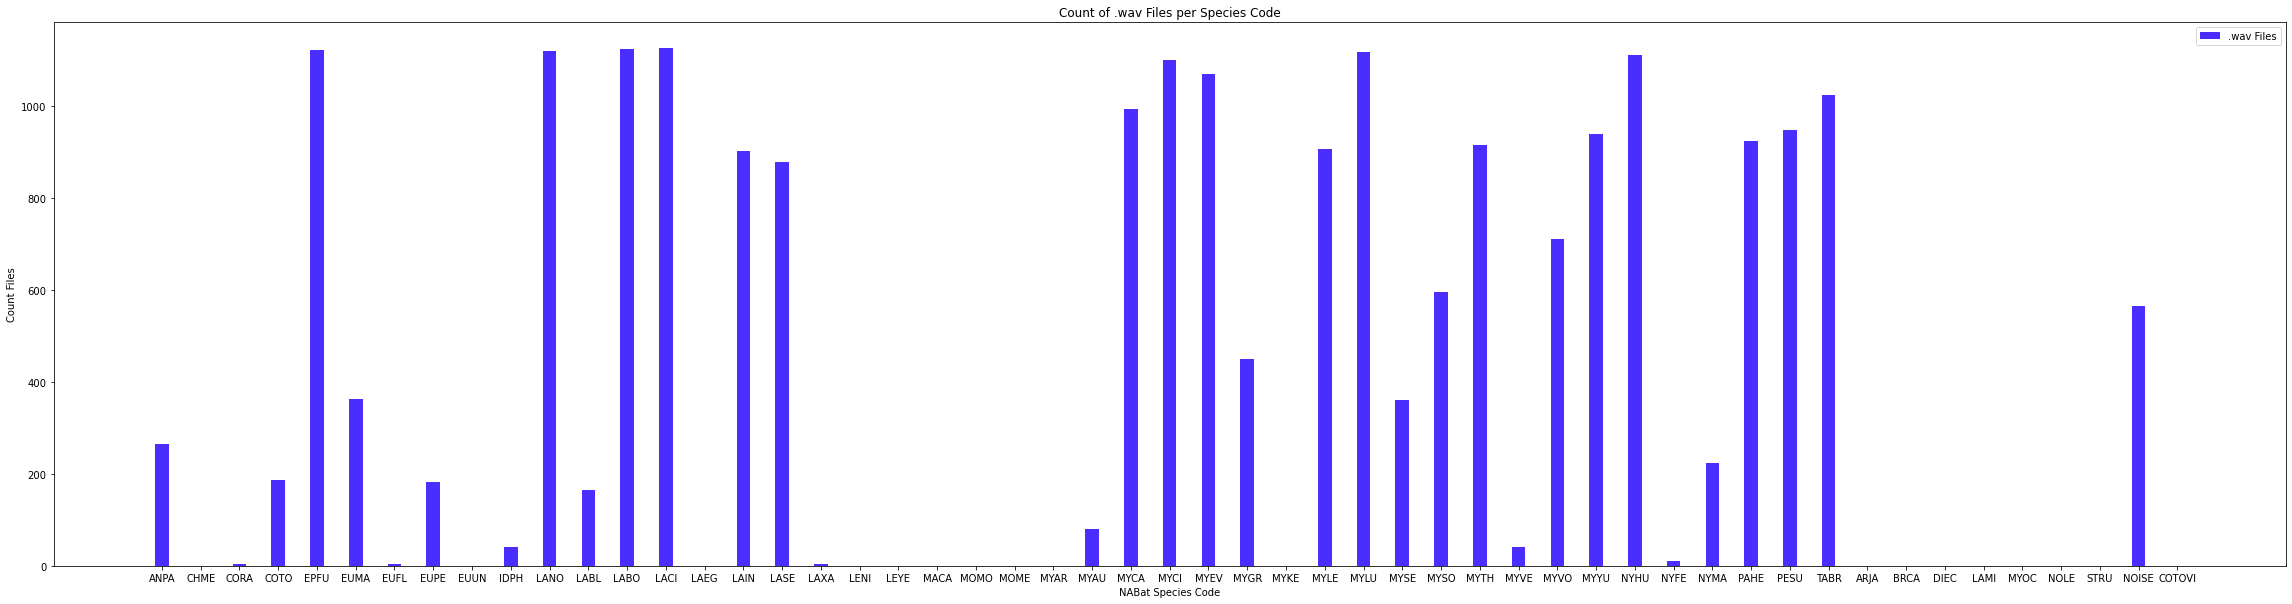

In [6]:
# Optional step.
# Create a plot visualizing our sample size of input data.

plt.close(fig='all')
class_names = []
wav_count = []
for s in species:
    class_names.append(s[1])
    wav_count.append(len(glob.glob('{}/{}/*.wav'.format(directory,s[1]), recursive=True)))

figure = plt.figure(figsize=(40, 10))

labels = class_names
count = np.array(wav_count)
print('Median files per class: ', np.median(count)//1)

width = 0.35 # the width of the bars: can also be len(x) sequence

plt.bar(labels, count, width, color="#4a2eff", label='.wav Files')

plt.ylabel('Count Files')
plt.xlabel('NABat Species Code')

plt.title('Count of .wav Files per Species Code')
plt.legend()
plt.show()


In [7]:

# Get the working directory and define an output directory for spectrograms.
dir_path = os.getcwd()
create_spectrogram_location = 'data/images'

# Given a species code, return a numeric id.
def get_manual_id(species_code):
    for s in species:
        if s.species_code == species_code:
            return s.id


# This method is meant to be called in parallel and will take a single file path
# and produce a spectrogram for each bat pulse detected within the recording.
def process_file(file_name):
    
    # Randomly and proprotionally assign files to the train, validate, and test sets.
    # 80% train, 10% validate, 10% test
    draw = None
    r = random.random()
    if r < 0.80:
        draw = 'train'
    elif r < 0.90:
        draw = 'test'
    else:
        draw = 'validate'
      
    # Open a new database connection.
    db = NABat_DB()
    
    # Get metadata about the recording from the file name. The expected naming convention is:
    # p_{nabat_project_id}_g{nabat_grts_id}_f{nabat_file_id}.wav
    # Example: "p163_g89522_f28390444.wav"
    
    species = file_name.split('/')[-2]
    manual_id = get_manual_id(species)
    grts_id = file_name.split('_')[1][1:]
    file_name_base = file_name.split('/')[-1].replace('.wav','')

    # Process file and return pulse metadata.
    spectrogram = Spectrogram()
    d = spectrogram.process_file(file_name)

    # Add the file to the database.
    file_id, draw = db.add_file(
                    d.name, d.duration, d.sample_rate, manual_id, grts_id, draw=draw)

    # For each pulse within file...
    for i, m in enumerate(d.metadata):
        # ...create a place to put the spectrogram.
        path = '{}/{}/{}/t_{}.png'.format(create_spectrogram_location, species, file_name_base, m.offset)
        Path('{}/{}/{}'.format(create_spectrogram_location, species, file_name_base)).mkdir(parents=True, exist_ok=True)
        
        # Add the pulse to the database.
        pulse_id = db.add_pulse(file_id, m.frequency,
                                  m.amplitude, 0, m.offset, m.time, None, path)
        # On success...
        if pulse_id:
            # ...create a spectrogram image surrounding the pulse and save to disk.
            img = spectrogram.make_spectrogram(m.window, d.sample_rate)
            img.save(path)
            img.close()
            
    # Close the database connection.
    db.conn.close()
      


In [8]:


# Use as many threads as we can, leaving one available to keep notebook responsive.
thread_count = (mp.cpu_count() - 1)
print('using {} threads'.format(thread_count))
 
# Gather wav files.
files = glob.glob('{}/**/*.wav'.format(directory), recursive=True)
progress = int(len(files) * 0.01)
progress = min(max(progress, 1), len(files))

# Start the creation process in parallel and report progress.
for i in range(0,len(files),progress):
    with Pool(thread_count) as p:
        p.map(process_file, files[i:i+progress])
        gc.collect()
        print('{}%'.format(int(i/progress)))


using 11 threads
0%
1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%
67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
100%


In [9]:
# Done!